### 농구 선수의 게임 데이터를 활용한 포지션 예측을 위한 데이터 정제
: NBA농구 선수들의 게임 기록을 데이터로 사용해서 특정 농구 선수의 포지션을 예측 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../Data/basketball.csv")
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [3]:
df.shape

(100, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   2P      100 non-null    float64
 4   TRB     100 non-null    float64
 5   AST     100 non-null    float64
 6   STL     100 non-null    float64
 7   BLK     100 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.4+ KB


#### Column Description
- Player : 선수 이름
- Pos : 포지션(SG: Shooting Guard, C: Center)
- 3P : 한 경기당 평균 3점슛 성공 횟수 
- 2P : 한 경기당 평균 2점슛 성공 횟수
- TRB : 한 경기당 평균 리바운드 성공 횟수
- AST : 한 경기당 평균 어시스트 성공 횟수
- STL : 한 경기당 평균 스틸 성공 횟수 
- BLK : 한 경기당 평균 블로킹 성공 횟수 

In [5]:
# 포지션 종류 파악
df.Pos.unique()

array(['SG', 'C'], dtype=object)

In [6]:
# 포지션별 갯수 파악
df.Pos.value_counts()

Pos
SG    50
C     50
Name: count, dtype: int64

### 포지션별 내용
- C : Center는 포스트 근처에서 슛을 블로킹하고, 리바운드 하며 바깥으로 쳐내며, 골대 근처에서 2점슛으로 득점을 하기도 한다.    
- SG : Shooting Guard는 코트내에서 3점슛등 장거리 슛을 해서 점수를 얻는 역할 

#### 데이터 시각화를 통한 EDA(탐색적 데이터 분석) 실시
: 데이터의 특징을 바탕으로 한 공간에 시각화 함으로써 머신러닝 학습에 필요한 특징과 불필요한 특징을 구분

In [7]:
#!pip install koreanize-matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

### 스틸, 2점슛 데이터 시각화 

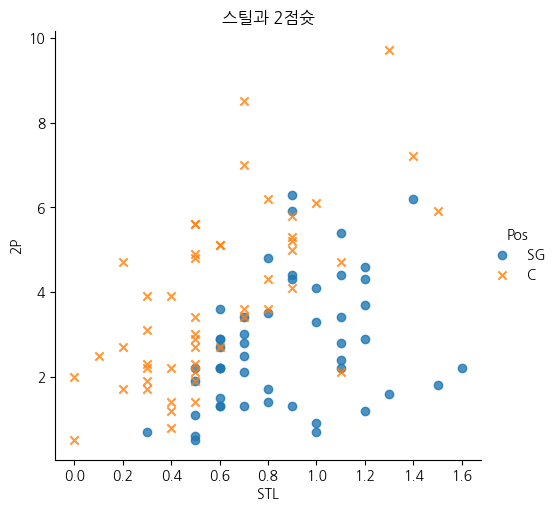

In [11]:
sns.lmplot(
    x='STL',
    y='2P',
    data=df,
    hue='Pos',
    markers=['o','x'],
    fit_reg=False
)

plt.title('스틸과 2점슛')
plt.show()

> 스틸과 2점슛의 속성으로 데이터를 분포시킬 경우 슈팅가드와 센터의 경계가 너무 근접해서 분류하기에 모호하다. 

### 어시스트와 2점슛 데이터 시각화

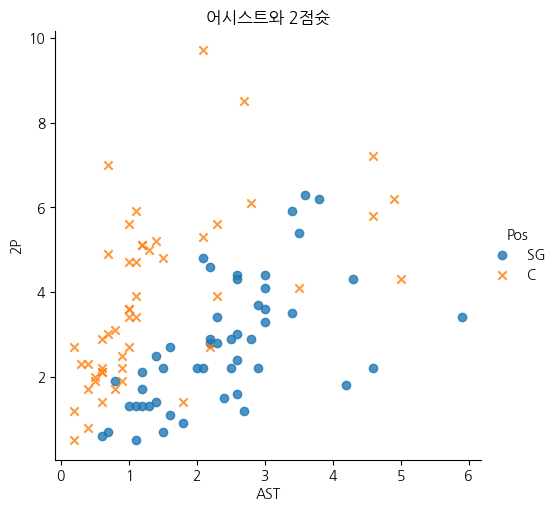

In [14]:
sns.lmplot(
    x='AST',
    y='2P',
    data=df,
    hue='Pos',
    markers=['o','x'],
    fit_reg=False
)

plt.title("어시스트와 2점슛")
plt.show()

> 어시스트와 2점슛의 속성으로 데이터를 분포시킬 경우 슈팅가드와 센터의 경계가 너무 근접해서 분류하기에 모호하다. 

#### 블로킹과 3점슛 데이터 시각화

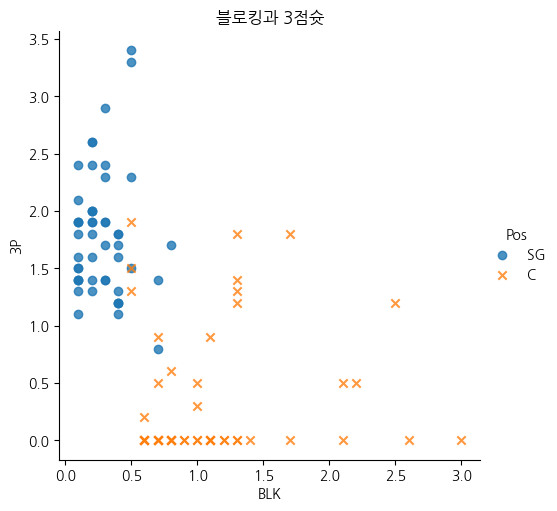

In [15]:
sns.lmplot(
    x='BLK',
    y='3P',
    data=df,
    hue='Pos',
    markers=['o','x'],
    fit_reg=False
)

plt.title("블로킹과 3점슛")
plt.show()

### 리바운드와 3점슛

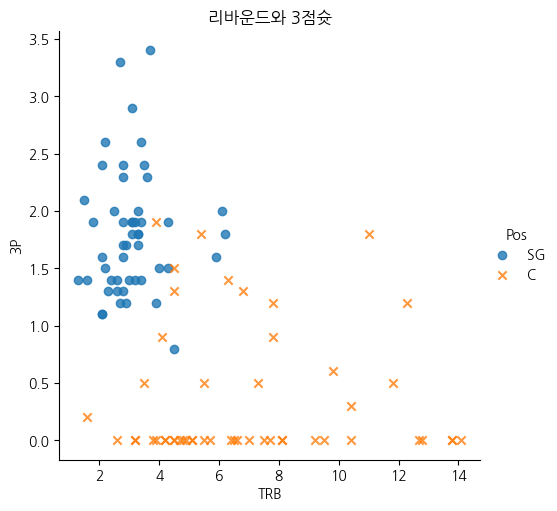

In [16]:
sns.lmplot(
    x='TRB',
    y='3P',
    data=df,
    hue='Pos',
    markers=['o','x'],
    fit_reg=False
)

plt.title("리바운드와 3점슛")
plt.show()

> #### EDA(Explorery Data Analysis:탐색적 데이터 분석) 결과
분별력이 없는 Feature를 데이터에서 제거하기 위해 시각화를 해본 결과     
2P, AST, STL은 분별력이 없는 것으로 판단됨.

In [17]:
# 분별력이 없는 Feature를 데이터에서 제거 : 2P, AST, STL 
df.drop(
    ['2P', 'AST', 'STL'],
    axis='columns',
    inplace=True
)

df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


### 학습데이터와 검증 데이터 나누어서 각각 파일로 저장하기

In [18]:
from sklearn.model_selection import train_test_split

In [20]:
# 다듬어진 데이터에서 20%를 테스트 데이터로 분류 
train, test = train_test_split(
                df,
                random_state=42,
                stratify=df.Pos,
                test_size=0.2
)

In [21]:
# 데이터 갯수 확인
print(train.shape)
print(test.shape)

(80, 5)
(20, 5)


In [22]:
train.head()

,Player,Pos,3P,TRB,BLK
31,Pau Gasol,C,0.9,7.8,1.1
5,Nicolas Batum,SG,1.8,6.2,0.4
19,Allen Crabbe,SG,1.7,2.9,0.3
32,Manu Ginobili,SG,1.3,2.3,0.2
36,Danny Green,SG,1.7,3.3,0.8


In [23]:
test.head()

,Player,Pos,3P,TRB,BLK
13,Avery Bradley,SG,2.0,6.1,0.2
58,Zach LaVine,SG,2.6,3.4,0.2
22,Troy Daniels,SG,2.1,1.5,0.1
4,Will Barton,SG,1.5,4.3,0.5
16,Willie Cauley-Stein,C,0.0,4.5,0.6


In [24]:
# 데이터 저장하기
# train : ../Data/baseketball_train.csv 
# test : ../Data/baseketball_test.csv 
train.to_csv("../Data/baseketball_train.csv", index=None)
test.to_csv("../Data/baseketball_test.csv", index=None)

In [25]:
pd.read_csv("../Data/baseketball_train.csv").head()

,Player,Pos,3P,TRB,BLK
0,Pau Gasol,C,0.9,7.8,1.1
1,Nicolas Batum,SG,1.8,6.2,0.4
2,Allen Crabbe,SG,1.7,2.9,0.3
3,Manu Ginobili,SG,1.3,2.3,0.2
4,Danny Green,SG,1.7,3.3,0.8


In [26]:
pd.read_csv("../Data/baseketball_test.csv").head()

,Player,Pos,3P,TRB,BLK
0,Avery Bradley,SG,2.0,6.1,0.2
1,Zach LaVine,SG,2.6,3.4,0.2
2,Troy Daniels,SG,2.1,1.5,0.1
3,Will Barton,SG,1.5,4.3,0.5
4,Willie Cauley-Stein,C,0.0,4.5,0.6
